# Installation der requirements
!pip install pygraphviz
!pip install pandas
!pip install pyarrow
!pip install seaborn
!pip install scikit-learn
'pip install tensorflow

In [1]:
# Import der Libraries
import math
import joblib
import numpy as np
import pandas as pd
import tensorflow as tf
import pygraphviz as pgv
import matplotlib.pyplot as plt
from IPython.display import Image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, RobustScaler
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import load_model

In [2]:
# Laden des Datensets
dfML = pd.read_csv('Cleaned_data.csv')
dfML.head()

,Zeitpunkt,Area,Maschine,Palette,Herkunft,Verweildauer,Area_Wechsel,BAU,Etage
0,2020-12-01 06:56:44.000,Montage BAU 3 UG,F710SPS1,105600,UB75SPS2,92.050000,True,3,UG
1,2020-12-01 07:13:10.000,Montage BAU 2 1.OG,AS71SPS1,105600,F710SPS1,16.433333,True,2,OG
2,2020-12-01 07:18:14.000,Montage BAU 2 1.OG,AS72SPS1,105600,AS71SPS1,5.066667,False,2,OG
3,2020-12-01 07:32:51.000,Montage BAU 3 UG,F720SPS1,105600,AS72SPS1,14.616667,True,3,UG
4,2020-12-01 07:35:05.000,Montage BAU 2 1.OG,FS71SPS1,105600,F720SPS1,2.233333,True,2,OG


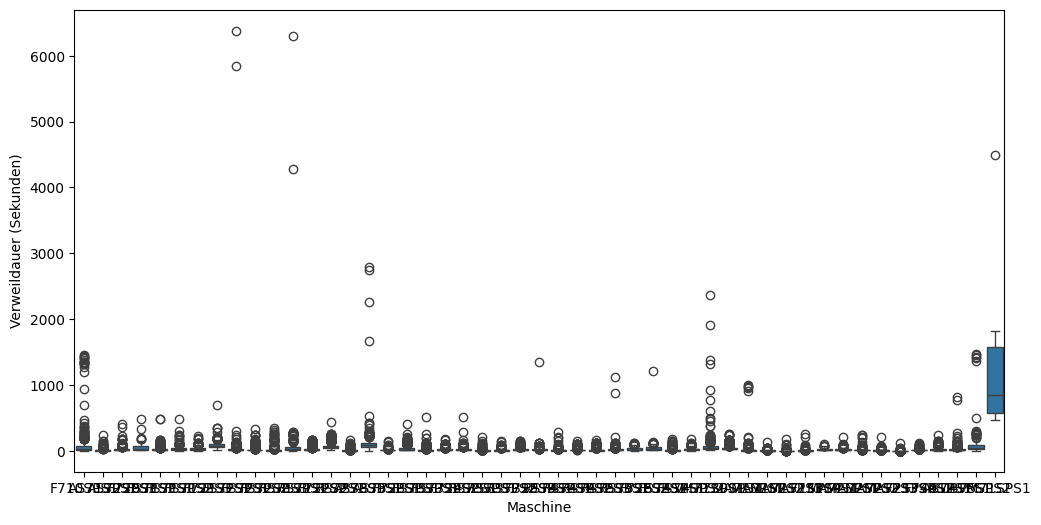

In [3]:
# Boxplot der Verweildauer für jede Maschine erstellen
sns.boxplot(x="Maschine", y="Verweildauer", data=dfML)
plt.xlabel("Maschine")
plt.ylabel("Verweildauer (Sekunden)")
plt.gcf().set_size_inches((12, 6))  # Erhöht die Breite auf 10 Zoll
plt.show()

In [4]:
dfML['Zeitpunkt'] = pd.to_datetime(dfML['Zeitpunkt'])
dfML = dfML.sort_values(by=['Zeitpunkt'], ascending=True).reset_index(drop=True)
dfML

,Zeitpunkt,Area,Maschine,Palette,Herkunft,Verweildauer,Area_Wechsel,BAU,Etage
0,2020-11-30 00:07:36,Montage BAU 2 1.OG,RS72SPS1,200060,F722SPS1,6.083333,True,2,OG
1,2020-11-30 00:14:42,Montage BAU 2 1.OG,RS72SPS1,201078,F722SPS1,2.716667,True,2,OG
2,2020-11-30 00:29:19,Montage BAU 2 1.OG,RS71SPS1,200465,FS72SPS2,28.183333,False,2,OG
3,2020-11-30 00:33:46,Montage BAU 3 UG,F740SPS1,201442,F733SPS1,26.050000,False,3,UG
4,2020-11-30 00:36:30,Montage BAU 2 1.OG,RS72SPS1,201181,F722SPS1,2.383333,True,2,OG
...,...,...,...,...,...,...,...,...,...
58307,2020-12-05 15:39:42,Montage BAU 2 1.OG,FS72SPS2,200005,FS72SPS1,96.816667,False,2,OG
58308,2020-12-05 15:43:55,Montage BAU 2 1.OG,FS72SPS3,200005,FS72SPS2,4.216667,False,2,OG
58309,2020-12-05 16:53:40,Montage BAU 2 1.OG,AS75SPS1,201157,AS73SPS1,126.383333,False,2,OG
58310,2020-12-05 22:19:02,Montage BAU 3 UG,F723SPS1,201701,AS75SPS1,401.366667,True,3,UG


In [5]:
le_maschine = LabelEncoder()
le_maschine.classes_ = sorted(dfML['Maschine'].unique())
dfML['Maschine_encoded'] = le_maschine.fit_transform(dfML['Maschine'])
dfML['Herkunft_encoded'] = le_maschine.fit_transform(dfML['Herkunft'])
le_bau = LabelEncoder()
dfML['BAU_encoded'] = le_bau.fit_transform(dfML['BAU'])
le_etage = LabelEncoder()
dfML['Etage_encoded'] = le_etage.fit_transform(dfML['Etage'])
dfML['Area_Wechsel_encoded'] = dfML['Area_Wechsel'].astype(int)
dfML['Zeitpunkt_encoded'] = pd.to_datetime(dfML['Zeitpunkt']).astype('int64') // 10**9

# Normalisierung der numerischen Variablen ('Verweildauer')
sc_verweildauer = RobustScaler()
dfML['Verweildauer_scaled'] = sc_verweildauer.fit_transform(dfML['Verweildauer'].
                                                            values.reshape(-1, 1))

joblib.dump(sc_verweildauer, "sc_verweildauer.pkl")
joblib.dump(le_maschine, "le_maschine.pkl")
joblib.dump(le_bau, "le_bau.pkl")
joblib.dump(le_etage, "le_etage.pkl")

dfML

,Zeitpunkt,Area,Maschine,Palette,Herkunft,Verweildauer,Area_Wechsel,BAU,Etage,Maschine_encoded,Herkunft_encoded,BAU_encoded,Etage_encoded,Area_Wechsel_encoded,Zeitpunkt_encoded,Verweildauer_scaled
0,2020-11-30 00:07:36,Montage BAU 2 1.OG,RS72SPS1,200060,F722SPS1,6.083333,True,2,OG,38,8,0,0,1,1606694856,-0.246225
1,2020-11-30 00:14:42,Montage BAU 2 1.OG,RS72SPS1,201078,F722SPS1,2.716667,True,2,OG,38,8,0,0,1,1606695282,-0.378858
2,2020-11-30 00:29:19,Montage BAU 2 1.OG,RS71SPS1,200465,FS72SPS2,28.183333,False,2,OG,36,21,0,0,0,1606696159,0.624425
3,2020-11-30 00:33:46,Montage BAU 3 UG,F740SPS1,201442,F733SPS1,26.050000,False,3,UG,16,15,1,2,0,1606696426,0.540381
4,2020-11-30 00:36:30,Montage BAU 2 1.OG,RS72SPS1,201181,F722SPS1,2.383333,True,2,OG,38,8,0,0,1,1606696590,-0.391989
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58307,2020-12-05 15:39:42,Montage BAU 2 1.OG,FS72SPS2,200005,FS72SPS1,96.816667,False,2,OG,21,20,0,0,0,1607182782,3.328299
58308,2020-12-05 15:43:55,Montage BAU 2 1.OG,FS72SPS3,200005,FS72SPS2,4.216667,False,2,OG,22,21,0,0,0,1607183035,-0.319764
58309,2020-12-05 16:53:40,Montage BAU 2 1.OG,AS75SPS1,201157,AS73SPS1,126.383333,False,2,OG,4,2,0,0,0,1607187220,4.493106
58310,2020-12-05 22:19:02,Montage BAU 3 UG,F723SPS1,201701,AS75SPS1,401.366667,True,3,UG,9,4,1,2,1,1607206742,15.326330


In [6]:
le_maschine.classes_

array(['AS71SPS1', 'AS72SPS1', 'AS73SPS1', 'AS74SPS1', 'AS75SPS1',
       'F710SPS1', 'F720SPS1', 'F721SPS1', 'F722SPS1', 'F723SPS1',
       'F724SPS1', 'F725SPS1', 'F726SPS1', 'F730SPS1', 'F731SPS1',
       'F733SPS1', 'F740SPS1', 'FS71SPS1', 'FS71SPS2', 'FS71SPS3',
       'FS72SPS1', 'FS72SPS2', 'FS72SPS3', 'FS73SPS1', 'FS73SPS2',
       'FS74SPS1', 'FS74SPS2', 'MA71SPS1', 'MA71SPS2', 'MA71SPS3',
       'MA71SPS4', 'MA72SPS1', 'MA72SPS2', 'MA72SPS3', 'MA72SPS4',
       'PM71SPS1', 'RS71SPS1', 'RS71SPS2', 'RS72SPS1', 'RS73SPS1',
       'RS73SPS2', 'RS73SPS3', 'RS74SPS1', 'RS74SPS2', 'RS74SPS3',
       'RS75SPS1', 'RS75SPS2', 'UB75SPS2', 'VH71SPS1'], dtype=object)

In [7]:
features = ['Maschine_encoded', 'Herkunft_encoded', 'BAU_encoded', 'Etage_encoded']
# Einlesen des gespeicherten Modells
model = load_model('LSTM_Process_Mining_2.keras')

dfML['Vorhersage'] = None

In [8]:
# Funktion zur Aufteilung der Daten in Sequenzen der Länge sequence_length
def split_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length + 1):
        sequence = data[i:i+sequence_length]
        sequences.append(sequence)
    return sequences

In [10]:
# Aufteilen der Daten in Sequenzen der Länge 20 für jedes Feature
sequence_length = 25
sequences = {}
for feature in features:
    sequences[feature] = split_sequences(dfML[feature].values, sequence_length)
    print(f"Feature: {feature}:")
    print(sequences[feature][0:3])

print(f"Länge sequence: {len(sequences[feature])}")
print(f"Länge Dataframe: {len(dfML)}")

Feature: Maschine_encoded:
[array([38, 38, 36, 16, 38, 21, 41, 41, 41,  1, 18, 19, 11, 22, 18, 19,  1,
       11, 42, 43, 42, 44, 19, 37,  7]), array([38, 36, 16, 38, 21, 41, 41, 41,  1, 18, 19, 11, 22, 18, 19,  1, 11,
       42, 43, 42, 44, 19, 37,  7, 42]), array([36, 16, 38, 21, 41, 41, 41,  1, 18, 19, 11, 22, 18, 19,  1, 11, 42,
       43, 42, 44, 19, 37,  7, 42,  6])]
Feature: Herkunft_encoded:
[array([ 8,  8, 21, 15,  8, 20, 24, 24, 24,  0, 17, 17, 41, 21, 17, 18,  0,
       41, 41, 42, 11, 11, 17, 36, 19]), array([ 8, 21, 15,  8, 20, 24, 24, 24,  0, 17, 17, 41, 21, 17, 18,  0, 41,
       41, 42, 11, 11, 17, 36, 19, 41]), array([21, 15,  8, 20, 24, 24, 24,  0, 17, 17, 41, 21, 17, 18,  0, 41, 41,
       42, 11, 11, 17, 36, 19, 41,  1])]
Feature: BAU_encoded:
[array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1], dtype=int64), array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0], dtype=int64), array([0, 1, 0, 0

In [11]:
# Vorhersagen für jede Sequenz machen und in eine neue Spalte schreiben
def predict_values():
    counter = 0
    skip_counter = 0
    for i in range(len(sequences[features[0]])):
        if dfML.at[i, 'Vorhersage'] == None:
            sequence = np.array([sequences[column][i] for column in features]).T  # Kombinieren der Sequenzen für alle Features
            sequence = sequence.reshape(1, sequence_length, len(features))  # Reshape für LSTM-Modell
            
            # Vorhersage für die Sequenz machen
            prediction = model.predict(sequence, verbose=0)
            dfML.at[i, 'Vorhersage'] = sc_verweildauer.inverse_transform(prediction[0][0].reshape(1, -1))[0]
    
            counter += 1
        else:
            skip_counter += 1
    
        if counter == 1000:
            break
    
    dfML.to_csv('Predicted_values.csv', index=False)
    return skip_counter, counter

In [12]:
import time
skip_counter, counter = predict_values()

while counter != 0:
    print(f"{skip_counter} Werte übersprungen. {counter} Werte neu predicted.")
    time.sleep(1)
    counter = predict_values()

0 Werte übersprungen. 1000 Werte neu predicted.
0 Werte übersprungen. (1000, 1000) Werte neu predicted.
0 Werte übersprungen. (2000, 1000) Werte neu predicted.
0 Werte übersprungen. (3000, 1000) Werte neu predicted.
0 Werte übersprungen. (4000, 1000) Werte neu predicted.
0 Werte übersprungen. (5000, 1000) Werte neu predicted.
0 Werte übersprungen. (6000, 1000) Werte neu predicted.
0 Werte übersprungen. (7000, 1000) Werte neu predicted.
0 Werte übersprungen. (8000, 1000) Werte neu predicted.
0 Werte übersprungen. (9000, 1000) Werte neu predicted.
0 Werte übersprungen. (10000, 1000) Werte neu predicted.
0 Werte übersprungen. (11000, 1000) Werte neu predicted.
0 Werte übersprungen. (12000, 1000) Werte neu predicted.
0 Werte übersprungen. (13000, 1000) Werte neu predicted.
0 Werte übersprungen. (14000, 1000) Werte neu predicted.
0 Werte übersprungen. (15000, 1000) Werte neu predicted.
0 Werte übersprungen. (16000, 1000) Werte neu predicted.
0 Werte übersprungen. (17000, 1000) Werte neu pre

KeyboardInterrupt: 

In [13]:
dfML.dropna(subset=['Vorhersage'], inplace=True)
dfML['residuen'] = (dfML['Verweildauer'] - dfML['Vorhersage']).abs()
dfML

,Zeitpunkt,Area,Maschine,Palette,Herkunft,Verweildauer,Area_Wechsel,BAU,Etage,Maschine_encoded,Herkunft_encoded,BAU_encoded,Etage_encoded,Area_Wechsel_encoded,Zeitpunkt_encoded,Verweildauer_scaled,Vorhersage,residuen
0,2020-11-30 00:07:36,Montage BAU 2 1.OG,RS72SPS1,200060,F722SPS1,6.083333,True,2,OG,38,8,0,0,1,1606694856,-0.246225,18.734627,12.651293
1,2020-11-30 00:14:42,Montage BAU 2 1.OG,RS72SPS1,201078,F722SPS1,2.716667,True,2,OG,38,8,0,0,1,1606695282,-0.378858,18.409925,15.693259
2,2020-11-30 00:29:19,Montage BAU 2 1.OG,RS71SPS1,200465,FS72SPS2,28.183333,False,2,OG,36,21,0,0,0,1606696159,0.624425,17.726328,10.457005
3,2020-11-30 00:33:46,Montage BAU 3 UG,F740SPS1,201442,F733SPS1,26.050000,False,3,UG,16,15,1,2,0,1606696426,0.540381,17.503092,8.546908
4,2020-11-30 00:36:30,Montage BAU 2 1.OG,RS72SPS1,201181,F722SPS1,2.383333,True,2,OG,38,8,0,0,1,1606696590,-0.391989,16.823883,14.44055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58283,2020-12-05 10:07:08,Montage BAU 3 UG,F724SPS1,200216,FS73SPS2,169.916667,True,3,UG,10,24,1,2,1,1607162828,6.208142,16.882444,153.034222
58284,2020-12-05 10:11:04,BAU 2 2.OG,RS73SPS1,200216,F724SPS1,3.933333,True,2,OG,39,10,0,0,1,1607163064,-0.330926,17.094389,13.161056
58285,2020-12-05 10:36:31,Montage BAU 2 1.OG,AS73SPS1,200130,RS72SPS1,36.083333,False,2,OG,2,38,0,0,0,1607164591,0.935653,17.18449,18.898843
58286,2020-12-05 10:46:45,Montage BAU 2 1.OG,AS74SPS1,200130,AS73SPS1,10.233333,False,2,OG,3,2,0,0,0,1607165205,-0.082731,17.064445,6.831112


In [26]:
print("Durchschnitt:", dfML['residuen'].mean())
print("Median:", dfML['residuen'].median())
print("Standardabweichung:", dfML['residuen'].std())
print("Minimum:", dfML['residuen'].min())
print("Maximum:", dfML['residuen'].max())
print("25. Perzentil:", dfML['residuen'].quantile(0.25))
print("75. Perzentil:", dfML['residuen'].quantile(0.75))

Durchschnitt: 20.219176935055543
Median: 12.321652475992838
Standardabweichung: 57.7451047827564
Minimum: 0.0003197987874337116
Maximum: 6289.3171980539955
25. Perzentil: 6.373351446787518
75. Perzentil: 15.870989004770916


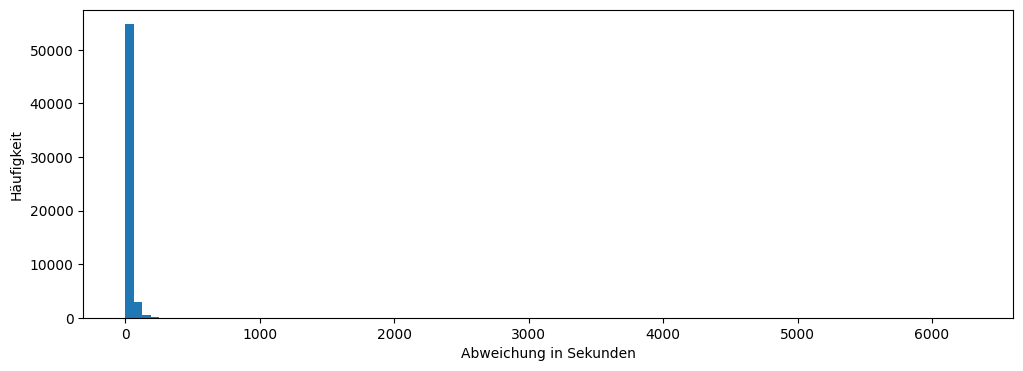

In [42]:
plt.figure(figsize=(12, 4))
plt.hist(dfML['residuen'], bins=100)  # Anzahl der Bins kann je nach Daten angepasst werden
plt.xlabel('Abweichung in Sekunden')
plt.ylabel('Häufigkeit')
plt.savefig('Residuen.png')
plt.show()

In [44]:
perzentil_99 = dfML['residuen'].quantile(0.99)
print(perzentil_99)

# Markieren von Anomalien
dfML['Anomalie'] = dfML['residuen'] > perzentil_99
dfML.to_csv('Predicted_values.csv', index=False)

134.25319928423554


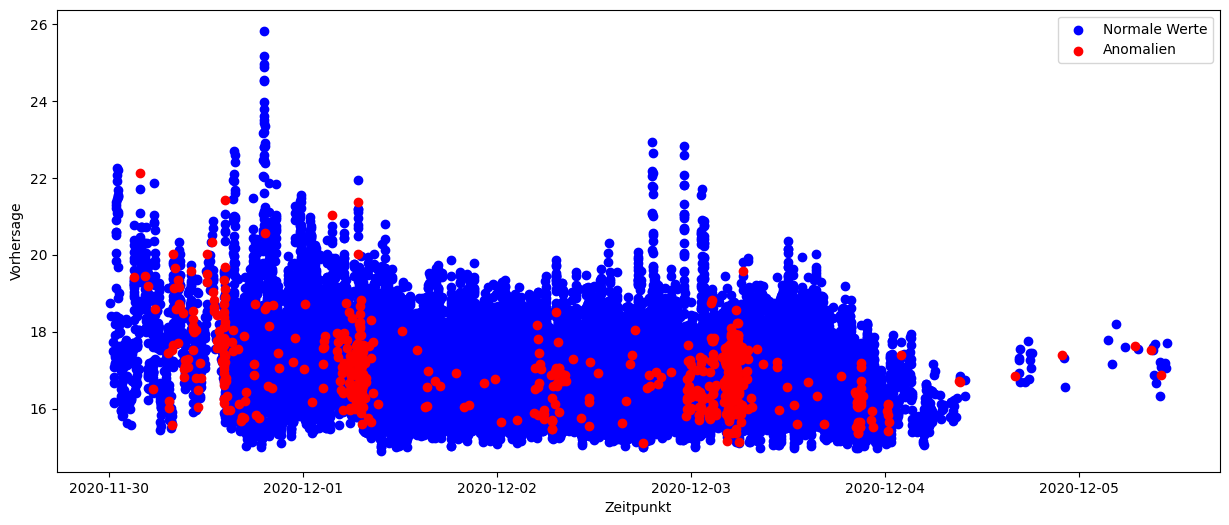

In [45]:
import matplotlib.pyplot as plt

# Aufteilen der Daten in normale und anomale Werte
normale_werte = dfML[dfML['Anomalie'] == False]
anomale_werte = dfML[dfML['Anomalie'] == True]

# Plotten der normalen und anomalen Werte
plt.figure(figsize=(15, 6)) 
plt.scatter(normale_werte['Zeitpunkt'], normale_werte['Vorhersage'], label='Normale Werte', color='blue')
plt.scatter(anomale_werte['Zeitpunkt'], anomale_werte['Vorhersage'], label='Anomalien', color='red')
plt.xlabel('Zeitpunkt')
plt.ylabel('Vorhersage')
plt.legend()
plt.savefig('Anomalien.png')
plt.show()

C:\Users\Alwin\AppData\Local\Temp\ipykernel_4644\2675385306.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  zeitfenster = df['Zeitpunkt'].dt.floor('30T')


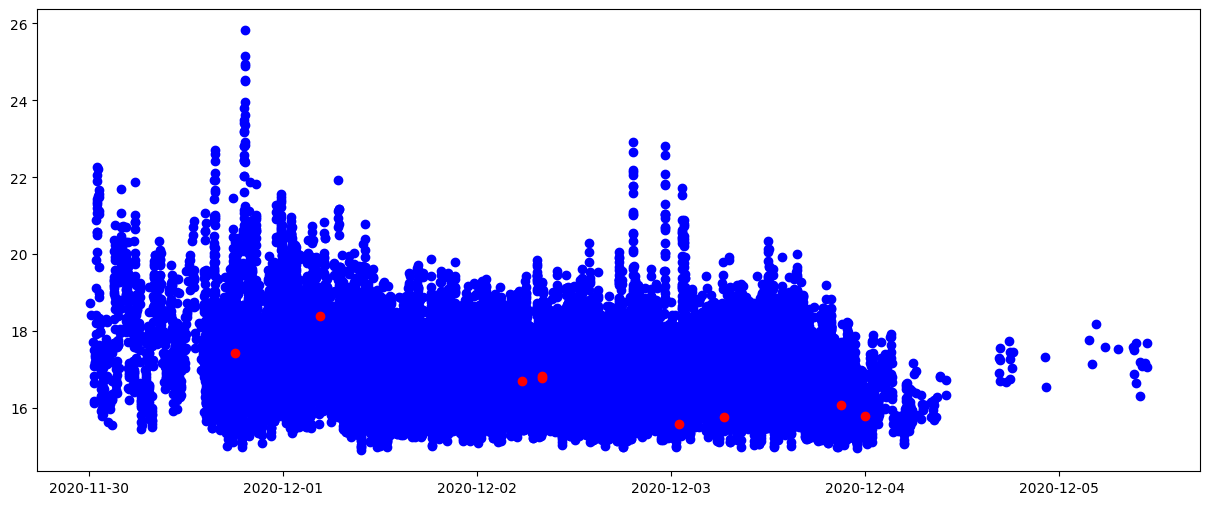

In [55]:
def filter_anomalien(df):
    zeitfenster = df['Zeitpunkt'].dt.floor('30T')
    gruppen = df.groupby(zeitfenster)
    anzahl_anomalien = gruppen['Anomalie'].sum()
    anomalie_fenster = anzahl_anomalien[anzahl_anomalien >= 3]
    anomale_werte = df[df['Zeitpunkt'].isin(anomalie_fenster.index)]
    return anomale_werte

anomale_werte = filter_anomalien(dfML.copy())

# Plotten der Daten
plt.figure(figsize=(15, 6))
plt.scatter(normale_werte['Zeitpunkt'], normale_werte['Vorhersage'], label='Normale Werte', color='blue')
plt.scatter(anomale_werte['Zeitpunkt'], anomale_werte['Vorhersage'], label='Anomalien', color='red')


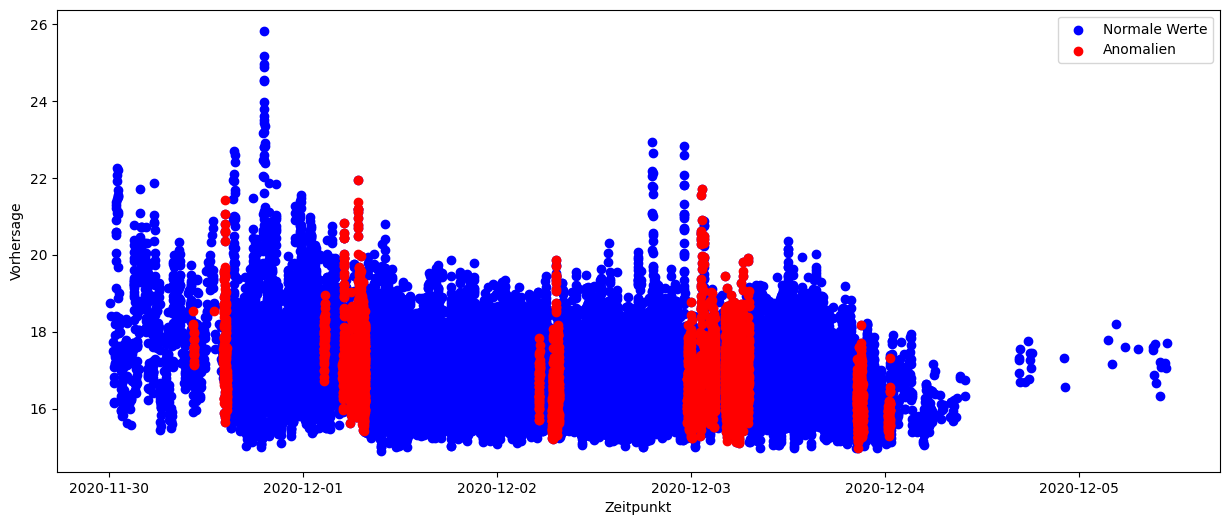

In [79]:
def filter_anomalien(df):
    # Gruppierung der Daten in Zeitfenstern pro Minute und Zählen der Anomalien
    gruppen = df.set_index('Zeitpunkt').rolling('15Min').sum()
    
    # Filtern der Anomalien, bei denen die Anzahl der Anomalien im Fenster größer oder gleich 3 ist
    anomalie_fenster = gruppen[gruppen['Anomalie'] >= 5]
    
    # Extrahieren der Zeilen im ursprünglichen DataFrame, die zu den anomalen Zeitpunkten gehören
    anomale_werte = df[df['Zeitpunkt'].isin(anomalie_fenster.index)]
    
    return anomale_werte

anomale_werte = filter_anomalien(dfML[['Zeitpunkt', 'Vorhersage', 'Anomalie']].copy())

# Plotten der Daten
plt.figure(figsize=(15, 6))
plt.scatter(normale_werte['Zeitpunkt'], normale_werte['Vorhersage'], label='Normale Werte', color='blue')
plt.scatter(anomale_werte['Zeitpunkt'], anomale_werte['Vorhersage'], label='Anomalien', color='red')
plt.xlabel('Zeitpunkt')
plt.ylabel('Vorhersage')
plt.legend()
plt.savefig('AlternativeAnomalien.png')